# Mount drive

In [98]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


# Unzipping dataset into colab instance

In [99]:
!unzip -q '/content/drive/MyDrive/pRCC.zip' -d '/content/'

#Installing required packages


In [2]:
!pip install pytorch_msssim

# Importing things

In [112]:
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from pytorch_msssim import SSIM
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split, Subset
import os
from torchvision.datasets import ImageFolder
from torch import nn, optim
from tqdm.auto import tqdm
import numpy as np

# Parameters


In [118]:
class Config:
  drive_path = "/content/drive/MyDrive"
  weights_path = f"{drive_path}/weights"

  #changed it
  datasets_path = f"/content/pRCC"

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  test_split = 0.2
  validation_split = 0.4

  learning_rate = 0.01
  weight_decay = 1e-4
  grad_clip = 0.1

  pRCC_batch_size = 16
  pRCC_img_resize_target = 512  # from 2000 -> 512 ( Too big to fit on machine!)

  # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  # 3. TRANSFORMS

  # constants
  # stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  #computed from the pRCC dataset itself
  stats = ((0.6843, 0.5012, 0.6436), (0.1962, 0.2372, 0.1771))

  # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

config = Config()

# Util functions


In [119]:
#Plotting functions
def plot_model_stats(experiment, epochs, training_losses, validation_losses, training_accuracy, validation_accuracy):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Plot data on each subplot and add labels
    axes[0, 0].plot(epochs, training_losses, marker="o", color="red")
    axes[0, 0].set_title(f'{experiment}: Training Loss vs Epochs')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Training Loss')

    axes[0, 1].plot(epochs, training_accuracy, marker="o", color="green")
    axes[0, 1].set_title(f'{experiment}: Training Accuracy vs Epochs')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Training Accuracy')

    axes[1, 0].plot(epochs, validation_losses, marker="o", color="red")
    axes[1, 0].set_title(f'{experiment}: Validation Loss vs Epochs')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Validation Loss')

    axes[1, 1].plot(epochs, validation_accuracy, marker="o", color="green")
    axes[1, 1].set_title(f'{experiment}: Validation Accuracy vs Epochs')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy')

    # Add space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    # close it properly
    plt.clf()
    plt.cla()
    plt.close()


def plot_model_stats(experiment, epochs, training_losses, validation_losses):
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))

    # Plot data on each subplot and add labels
    axes[0].plot(epochs, training_losses, marker="o", color="red")
    axes[0].set_title(f'{experiment}: Training Loss vs Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Training Loss')

    axes[1].plot(epochs, validation_losses, marker="o", color="red")
    axes[1].set_title(f'{experiment}: Validation Loss vs Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Validation Loss')

    # Add space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    # close it properly
    plt.clf()
    plt.cla()
    plt.close()


# Loss criterion

In [120]:
class SSIMLoss(nn.Module):
    def __init__(self):
        super(SSIMLoss, self).__init__()
        self.ssim = SSIM()

    def forward(self, x, y):
        # Calculate SSIM
        ssim_value = self.ssim(x, y)
        # Subtract SSIM from 1
        loss = 1 - ssim_value
        return loss

In [121]:
# related to datasets

'''
Wrapper on top of dataloader to move tensors to device
'''
class DeviceDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=True, device=config.device):
        super().__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle
        )
        self.device = device

    def __iter__(self):
        for batch in super().__iter__():
            yield self._move_to_device(batch)

    def _move_to_device(self, batch):
        if isinstance(batch, torch.Tensor):
            return batch.to(self.device)
        elif isinstance(batch, (list, tuple)):
            return [self._move_to_device(item) for item in batch]
        elif isinstance(batch, dict):
            return {key: self._move_to_device(value) for key, value in batch.items()}
        else:
            return batch

def create_mini_dataset(dataset, num_samples):
    '''
    Function to be used locally for checking if the model runs or not!

    :param dataset:
    :param num_samples:
    :return:
    '''
    subset_indices = torch.randperm(len(dataset))[:num_samples]
    subset_dataset = Subset(dataset, subset_indices)
    return subset_dataset

def calculate_mean_and_std_of_dataset(dataset):
    '''
    Useful when determining what transforms to set

    :param dataset:
    :return:
    '''
    # dataset =  ImageFolder(root=self.path, transform=transforms.ToTensor())

    # Initialize variables to accumulate mean and standard deviation
    mean = torch.zeros(3)
    std = torch.zeros(3)

    # Loop through the dataset to compute mean and standard deviation
    for img, _ in dataset:
        mean += img.mean(1).mean(1)
        std += img.view(3, -1).std(1)

    # Calculate the mean and standard deviation
    mean /= len(dataset)
    std /= len(dataset)

    return (tuple(mean.tolist()), tuple(std.tolist()))

# Dataset


In [122]:
class pRCCDataset:
    def __init__(self, path, batch_size=config.pRCC_batch_size, resize_to=config.pRCC_img_resize_target, test_split=config.test_split, validation_split=config.validation_split):
        # constants
        self.path = path
        self.test_split = test_split
        self.validation_split = validation_split
        self.resize_to = resize_to
        self.batch_size = batch_size

        # transformations
        self.transforms = [
            # basic transformation
            transforms.Compose([
                transforms.Resize((resize_to, resize_to)),  # Resize images to a fixed size
                transforms.ToTensor(),
                transforms.Normalize(*config.stats)
            ]),
            # transformation with flips
            transforms.Compose([
                transforms.Resize((resize_to, resize_to)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(*config.stats)
            ]),
            # transformation with rotation
            transforms.Compose([
                transforms.Resize((resize_to, resize_to)),
                transforms.RandomRotation(degrees=15),
                transforms.ToTensor(),
                transforms.Normalize(*config.stats)
            ]),
            # transformation with rotation & flips
            transforms.Compose([
                transforms.Resize((resize_to, resize_to)),
                transforms.RandomRotation(degrees=15),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(*config.stats)
            ])
        ]

        # create dataset
        self.dataset = self.construct_dataset_with_augmentation()

    def get_dataset(self, transformation):
        '''
        Given a folder with sub folders containing images, get all the images along with applying transformations

        :param inp_path:
        :param transformations:
        :return:
        '''
        image_folder =  ImageFolder(root=self.path, transform=transformation)

        #Uncomment for local testing
        # image_folder = create_mini_dataset(image_folder, 50)

        return image_folder

    def construct_dataset_with_augmentation(self):
        '''

        :return: Concatenated dataset with all augmentations
        '''
        augmentations = []
        for transformation in self.transforms:
            augmentations.append(self.get_dataset(transformation))
        return ConcatDataset(augmentations)

    def get_dataloaders(self):
        '''

        :return: the Train, Val and test dataloaders
        '''
        # Calculate the number of samples to use for validation
        num_total_samples = len(self.dataset)

        # find the no of train samples
        num_test_samples = int(num_total_samples * self.test_split)
        num_train_samples = num_total_samples - num_test_samples

        num_validation_samples = int(num_test_samples * self.validation_split)
        num_test_samples = num_test_samples - num_validation_samples

        # Split the full dataset into train and test sets
        train_dataset, test_dataset, validation_dataset = random_split(self.dataset, [num_train_samples, num_test_samples, num_validation_samples])

        # Create DataLoaders for validation and test sets
        return DeviceDataLoader(train_dataset, self.batch_size), DeviceDataLoader(test_dataset, self.batch_size), DeviceDataLoader(validation_dataset, self.batch_size)


# Generic Module


In [123]:
class Module:
    def __init__(self, name, dataset, model, save_dir, device=config.device):
        '''

        :param name: name of the experiement
        :param dataset: the dataset object which implements the method get_dataloaders()
        :param model: the model architecture used
        :param loss_criterion: the loss function used
        :param save_dir: path where the model weights can be saved
        '''
        self.name = name
        self.dataset = dataset
        self.save_dir = save_dir

        # create the directory if it doesnt exist!
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(os.path.join(self.save_dir, self.name), exist_ok=True)

        self.model = model
        self.device = device
        self.batch_size = self.dataset.batch_size

        # get loaders (each of which already moves tensors to device)
        self.train_loader, self.test_loader, self.val_loader = self.dataset.get_dataloaders()

        # Adam optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    # find the most recent file and return the path
    def get_model_checkpoint_path(self, epoch_num=None):
        directory = os.path.join(self.save_dir, self.name)
        if epoch_num == None:
            # Get a list of all files in the directory
            files = os.listdir(directory)

            # Filter out only the files (exclude directories)
            files = [f for f in files if os.path.isfile(os.path.join(directory, f))]

            # Sort the files by their modification time in descending order (most recent first)
            files.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)), reverse=True)

            # Get the name of the most recently added file
            model_file = files[0] if files else None
        else:
            model_file = f"model_epoch_{epoch_num}.pt"
        return os.path.join(directory, model_file)

    # main train code
    def train(self,
              num_epochs,
              resume_epoch_num=None,
              load_from_checkpoint=False,
              epoch_saver_count=2):
        '''

        :param num_epochs:
        :param resume_epoch_num: just the name of the model checkpoint
        :param load_from_checkpoint: boolean indicating if we need to load from checkpoint or not
        :param epoch_saver_count:
        :return:
        '''
        torch.cuda.empty_cache()

        # initialize the params from the saved checkpoint
        self.init_params_from_checkpoint_hook(load_from_checkpoint, resume_epoch_num)

        # set up scheduler
        self.init_scheduler_hook(num_epochs)

        # Custom progress bar for total epochs with color and displaying average epoch loss
        total_progress_bar = tqdm(
            total=num_epochs, desc=f"Total Epochs", position=0,
            bar_format="{desc}: {percentage}% |{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]",
            dynamic_ncols=True, ncols=100, colour='red'
        )

        # Train loop
        for epoch in range(self.start_epoch, self.start_epoch + num_epochs):
            # Custom progress bar for each epoch with color
            epoch_progress_bar = tqdm(
                total=len(self.train_loader),
                desc=f"Epoch {epoch + 1}/{self.start_epoch + num_epochs}",
                position=1,
                leave=False,
                dynamic_ncols=True,
                ncols=100,
                colour='green'
            )

            # set model to train mode
            self.model.train()

            # set the epoch training loss
            epoch_training_loss = 0.0

            # iterate over each batch
            for batch_idx, data in enumerate(self.train_loader):
                loss = self.calculate_loss_hook(data)
                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_value_(self.model.parameters(), config.grad_clip)

                self.optimizer.step()
                self.optimizer.zero_grad()

                # scheduler update
                if self.scheduler:
                    self.scheduler.step()

                # add to epoch loss
                epoch_training_loss += loss.item()

                # Update the epoch progress bar (overwrite in place)
                postfix = {
                    "loss": loss.item()
                }

                # e.g. computes things like accuracy
                batch_stats = self.calculate_train_batch_stats_hook()

                postfix.update(batch_stats)

                epoch_progress_bar.set_postfix(postfix)
                epoch_progress_bar.update(1)

            # close the epoch progress bar
            epoch_progress_bar.close()

            # calculate average epoch train statistics
            avg_train_stats = self.calculate_avg_train_stats_hook(epoch_training_loss)

            # calculate validation statistics
            avg_val_stats = self.validation_hook()

            # Store running history
            self.store_running_history_hook(epoch, avg_train_stats, avg_val_stats)

            # Show epoch stats (NOTE: Can clear the batch stats here)
            epoch_postfix = self.calculate_and_print_epoch_stats_hook(avg_train_stats, avg_val_stats)

            # Update the total progress bar
            total_progress_bar.set_postfix(epoch_postfix)

            # Close tqdm bar
            total_progress_bar.update(1)

            # Save model checkpoint periodically
            need_to_save_model_checkpoint = (epoch + 1) % epoch_saver_count == 0
            if need_to_save_model_checkpoint:
                print(f"Going to save model {self.name} @ Epoch:{epoch + 1}")
                self.save_model_checkpoint_hook(epoch, avg_train_stats, avg_val_stats)

        # Close the total progress bar
        total_progress_bar.close()

        # Return the current state
        return self.get_current_running_history_state_hook()

    # hooks
    def init_params_from_checkpoint_hook(self, load_from_checkpoint, resume_checkpoint):
        raise NotImplementedError("Need to implement hook for initializing params from checkpoint")

    def init_scheduler_hook(self, num_epochs):
        raise NotImplementedError("Need to implement hook for creating a scheduler. If no scheduler is required don't write any implementation for it")

    def calculate_loss_hook(self, data):
        raise NotImplementedError("Need to implement hook for computing the custom loss value")

    def calculate_train_batch_stats_hook(self):
        raise NotImplementedError("Need to implement this hook for computing the batch statistics like accuracy")

    def calculate_avg_train_stats_hook(self):
        raise NotImplementedError("Need to implement this hook for calculating train loss and train accuracy if applicable")

    def validation_hook(self):
        raise NotImplementedError("Need to implement this hook to calculate the validation stats")

    def calculate_and_print_epoch_stats_hook(self):
        raise NotImplementedError("Need to implement this hook to calculate and print the epoch statistics and return the postfix dictinoary")

    def store_running_history_hook(self, epoch, avg_train_stats, avg_val_stats):
        raise NotImplementedError("Need to implement this hook to store the running history of stats for each epoch")

    def save_model_checkpoint_hook(self, epoch, avg_train_stats, avg_val_stats):
        raise NotImplementedError("Need to implement this hook to save the model checkpoints")

    def get_current_running_history_state_hook(self):
        raise NotImplementedError("Need to implement this hook to return the history after training the model")


# pRCC Module

In [125]:
class pRCCModule(Module):
    def __init__(self, name, dataset, model, save_dir):
        super().__init__(name, dataset, model, save_dir)

        # structured similarity index
        self.loss_criterion = SSIMLoss()

        #L2 Loss
        # self.loss_criterion = nn.MSELoss()

        # Values which can change based on loaded checkpoint
        self.start_epoch = 0
        self.epoch_numbers = []
        self.training_losses = []
        self.validation_losses = []

    # hooks
    def init_params_from_checkpoint_hook(self, load_from_checkpoint, resume_epoch_num):
        if load_from_checkpoint:
            # NOTE: resume_epoch_num can be None here if we want to load from the most recently saved checkpoint!
            checkpoint_path = self.get_model_checkpoint_path(resume_epoch_num)
            checkpoint = torch.load(checkpoint_path)

            # load previous state
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            # Things we are keeping track of
            self.start_epoch = checkpoint['epoch']
            self.epoch_numbers = checkpoint['epoch_numbers']
            self.training_losses = checkpoint['training_losses']
            self.validation_losses = checkpoint['validation_losses']

            print(f"Model checkpoint for {self.name} is loaded from {checkpoint_path}!")

    def init_scheduler_hook(self, num_epochs):
        # optimizer is already defined in the super class constructor at this point
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            config.learning_rate,
            epochs=num_epochs,
            steps_per_epoch=len(self.train_loader)
        )
        # print(f"Initialized scheduler")

    def calculate_loss_hook(self, data):
        images, _ = data
        latent_encoding, predictions = self.model(images)
        loss = self.loss_criterion(images, predictions)
        return loss

    def calculate_train_batch_stats_hook(self):
        # Note: No accuracy to compute so leaving it as is.
        return dict()

    def calculate_avg_train_stats_hook(self, epoch_training_loss):
        # NOTE: no need to calculate avg training accuracy here
        avg_training_loss_for_epoch = epoch_training_loss / len(self.train_loader)
        return {
            "avg_training_loss": avg_training_loss_for_epoch
        }

    def validation_hook(self):
        '''
        :return: avg val loss for that epoch
        '''
        val_loss = 0.0

        # set to eval mode
        self.model.eval()

        with torch.no_grad():
            for val_batch_idx, val_data in enumerate(self.val_loader):
                val_images, _ = val_data
                _, val_predictions = self.model(val_images)

                val_loss += self.loss_criterion(val_images, val_predictions).item()

        # Calculate average validation loss for the epoch
        avg_val_loss_for_epoch = val_loss / len(self.val_loader)

        # show some sample predictions
        self.show_sample_reconstructions(self.val_loader)

        return {
            "avg_val_loss_for_epoch": avg_val_loss_for_epoch
        }

    def store_running_history_hook(self, epoch, avg_train_stats, avg_val_stats):
        self.epoch_numbers.append(epoch + 1)
        self.training_losses.append(avg_train_stats["avg_training_loss"])
        self.validation_losses.append(avg_val_stats["avg_val_loss_for_epoch"])

    def calculate_and_print_epoch_stats_hook(self, avg_train_stats, avg_val_stats):
        print(f"Epoch loss: {avg_train_stats['avg_training_loss']} | Val loss: {avg_val_stats['avg_val_loss_for_epoch']}")
        return {
            "epoch_loss": avg_train_stats["avg_training_loss"],
            "val_loss": avg_val_stats["avg_val_loss_for_epoch"]
        }

    def save_model_checkpoint_hook(self, epoch, avg_train_stats, avg_val_stats):
        # set it to train mode to save the weights (but doesn't matter apparently!)
        self.model.train()

        # create the directory if it doesn't exist
        model_save_directory = os.path.join(self.save_dir, self.name)
        os.makedirs(model_save_directory, exist_ok=True)

        # Checkpoint the model at the end of each epoch
        checkpoint_path = os.path.join(model_save_directory, f'model_epoch_{epoch + 1}.pt')
        torch.save(
            {
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'epoch': epoch + 1,
                'epoch_numbers': self.epoch_numbers,
                'training_losses': self.training_losses,
                'validation_losses': self.validation_losses
            },
            checkpoint_path
        )
        print(f"Saved the model checkpoint for experiment {self.name} for epoch {epoch + 1}")

    def get_current_running_history_state_hook(self):
        return self.epoch_numbers, self.training_losses, self.validation_losses

    # test code
    def test_model(self):
        test_loss = 0.0

        # set to eval mode
        self.model.eval()

        with torch.no_grad():
            for val_batch_idx, val_data in enumerate(self.test_loader):
                test_images, _ = val_data
                _, test_predictions = self.model(test_images)

                test_loss += self.loss_criterion(test_images, test_predictions).item()

        # Calculate average validation loss for the epoch
        avg_test_loss = test_loss / len(self.test_loader)

        # show some sample predictions
        self.show_sample_reconstructions(self.test_loader)

        return {
            "avg_test_loss": avg_test_loss
        }

    # util code
    def show_sample_reconstructions(self, dataloader, num_samples=1):
        self.model.eval()

        # Get random samples
        sample_indices = torch.randperm(len(dataloader.dataset))[:num_samples]
        subset_dataset = Subset(dataloader.dataset, sample_indices)

        dataloader = DeviceDataLoader(subset_dataset, self.batch_size)

        # Create a subplot grid
        fig, axes = plt.subplots(num_samples, 2, figsize=(9, 9))

        with torch.no_grad():
            for i, val_data in enumerate(dataloader):
                sample_image, _ = val_data

                # Forward pass through the model
                _, predicted_image = self.model(sample_image)

                # squeeze it
                sample_image = sample_image.squeeze().to("cpu")
                predicted_image = predicted_image.squeeze().to("cpu")

                # keep it ready for showcasing in matplotlib
                predicted_image = predicted_image.permute(1, 2, 0).numpy().astype(np.uint8)
                sample_image = sample_image.permute(1, 2, 0).numpy().astype(np.uint8)

                axes[0].imshow(sample_image)
                axes[0].set_title(f"Sample Original Image", color='green')
                axes[0].axis('off')

                axes[1].imshow(predicted_image)
                axes[1].set_title(f"Sample Reconstructed Image", color='red')
                axes[1].axis('off')

        plt.tight_layout()
        plt.show()

# Model


In [126]:
class pRCCUnetAutoencoder(nn.Module):
    def __init__(self, latent_dim_size=2048):
        super().__init__()

        # constants
        self.latent_dim_size = latent_dim_size

        # Encoding path.
        self.encode_conv_1 = self.encoding_step(3, 32)
        self.encode_conv_2 = self.encoding_step(32, 64)
        self.encode_conv_3 = self.encoding_step(64, 128)
        self.encode_conv_4 = self.encoding_step(128, 256)
        self.encode_conv_5 = self.encoding_step(256, 256)  # Reduced to 256 channels

        # Linear layers for latent encoding
        self.avg_pool = nn.AvgPool2d(kernel_size=3, stride=1)  # Reduce dimensions

    def forward(self, x):
        # Encoding
        encode_5 = self.encode_conv_1(x)  # Shape: (batchsize, 32, 512, 512)
        encode_4 = self.encode_conv_2(encode_5)  # Shape: (batchsize, 64, 256, 256)
        encode_3 = self.encode_conv_3(encode_4)  # Shape: (batchsize, 128, 128, 128)
        encode_2 = self.encode_conv_4(encode_3)  # Shape: (batchsize, 256, 64, 64)
        encode_1 = self.encode_conv_5(encode_2)  # Shape: (batchsize, 256, 32, 32)

        # Decoding
        decode_1 = self.decoding_step(encode_1, 256,
                                      256)  # Output is now in decode_1 with shape (batchsize, 256, 64, 64)
        decode_2 = self.decoding_step(decode_1 + encode_2, 256, 128)  # Shape: (batchsize, 128, 128, 128)
        decode_3 = self.decoding_step(decode_2 + encode_3, 128, 64)  # Shape: (batchsize, 64, 256, 256)
        decode_4 = self.decoding_step(decode_3 + encode_4, 64, 32)  # Shape: (batchsize, 32, 512, 512)
        decode_5 = self.decoding_step(decode_4 + encode_5, 32, 3)  # Shape: (batchsize, 3, 1024, 1024)

        # Latent Encoding
        latent_encoding = self.linear_latent(encode_1)  # Shape: (batchsize, 2048)

        return latent_encoding, decode_5

    def encoding_step(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # BatchNorm added
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # BatchNorm added
            nn.AvgPool2d(kernel_size=2, stride=2),  # Always include avg pool
        )

    def decoding_step(self, x, in_channels, out_channels, ct_padding=0, conv_padding=1):
        #need to explicitly move the convTranspose to correct device!
        x = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2,
                               padding=ct_padding).to(config.device)(x)  # Upsample
        x = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=conv_padding)\
            .to(config.device)(x)  # Convolution
        return x

    def linear_latent(self, x):
        # Apply pooling to reduce dimensions
        x = nn.AvgPool2d(kernel_size=2).to(config.device)(x)  # Shape: (batchsize, 256, 16, 16)
        x = nn.MaxPool2d(kernel_size=2).to(config.device)(x)  # Shape: (batchsize, 256, 8, 8)
        x = nn.AdaptiveMaxPool2d((4, 4)).to(config.device)(x)  # Shape: (batchsize, 256, 4, 4)

        # Flatten the tensor
        x = nn.Flatten().to(config.device)(x)  # Shape: (batchsize, 256 * 4 * 4)

        # Apply linear layers to further reduce dimensions
        x = nn.Linear(256 * 4 * 4, 4096).to(config.device)(x)  # Shape: (batchsize, 4096)
        x = nn.Linear(4096, self.latent_dim_size).to(config.device)(x)  # Shape: (batchsize, 2048)
        return x

# Creating the dataset

In [127]:
path = os.path.abspath(config.datasets_path)
pRCC_dataset = pRCCDataset(path)

# Training code

In [128]:
name = "pRCC_Unet_Autoencoder"
model = pRCCUnetAutoencoder().to(config.device)
save_dir = os.path.abspath(config.weights_path)
pRCC_module = pRCCModule(name, pRCC_dataset, model, save_dir)

In [ ]:
epoch_numbers, training_losses, validation_losses = pRCC_module.train(5, epoch_saver_count=1)

In [80]:
epoch_numbers, training_losses, validation_losses = pRCC_module.train(10, epoch_saver_count=1, load_from_checkpoint=True, resume_epoch_num=5)

# Testing the model

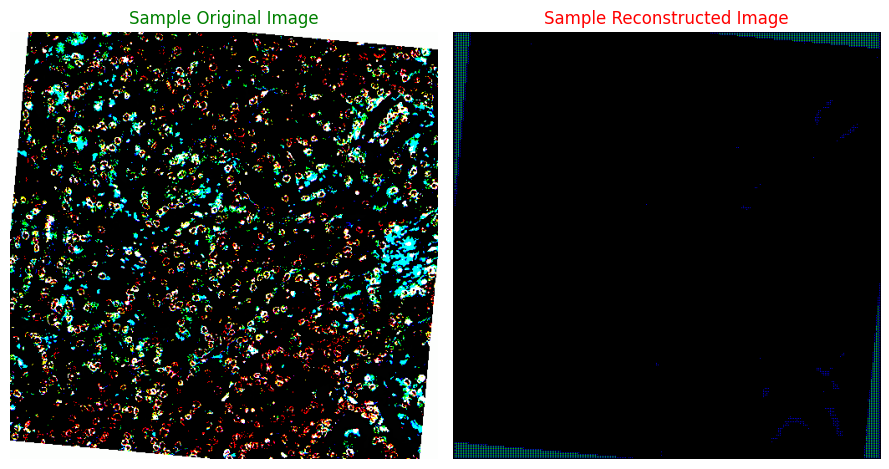

In [130]:
test_stats = pRCC_module.test_model()

In [ ]:
test_stats

# Plotting the graphs

In [ ]:
plot_model_stats(name, epoch_numbers, training_losses, validation_losses)